# Empirical Risk Minimization (ERM)

Empirical risk minimization (ERM) is a principle in statistical learning theory which defines a family of learning algorithms and is used to give theoretical bounds on their performance.

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm, tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, \
    GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, f1_score

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
np.random.seed(42)

In [4]:
COLORS = ["b", "g", "r", "c", "m", "y", "k", "w", "pink", "salmon", "indigo", "lime"]

In [5]:
weeks = range(1, 13)

In [6]:
_course = 'ca116'

In [7]:
training_and_validation_years = [
    (2016, 2017),
    (2017, 2018)
]

In [8]:
exams = [4, 8, 12]

Dictionary of given a week, which exam should we predicting next?

In [9]:
def get_week_to_exam(exam_weeks):
    week_to_exam = {}
    curr = exam_weeks[-1]
    for i in reversed(range(12)):
        week = i + 1
        if week in exam_weeks:
            curr = week
        week_to_exam[week] = curr
    return week_to_exam

In [10]:
week_to_exam = get_week_to_exam(exams)

In [11]:
week_to_exam

{12: 12, 11: 12, 10: 12, 9: 12, 8: 8, 7: 8, 6: 8, 5: 8, 4: 4, 3: 4, 2: 4, 1: 4}

In [12]:
def get_scorings():
    return [
        "roc_auc",
        "f1",
        "precision",
        "recall",
        "accuracy",
        "average_precision",
    ]

In [13]:
def calculate_cross_val_score(algorithm, X, Y, nfolds, scoring="roc_auc"):
    cv = StratifiedKFold(Y, n_folds=nfolds)
    scores = cross_val_score(algorithm, X, Y, scoring=scoring, cv=cv)
    return scores.mean(), scores.std()

In [14]:
def get_bag_classifiers():
    return [
        LogisticRegression(C=1.0, solver='liblinear', random_state=0),
        RandomForestClassifier(n_estimators=10, random_state=0),
        tree.DecisionTreeClassifier(random_state=0),
        KNeighborsClassifier(n_neighbors=12),
        MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=0)
        # svm.SVC(kernel="linear", C=1.0, random_state=0, probability=True),
        # svm.SVC(kernel="rbf", gamma=0.7, C=1.0, random_state=0),
        #AdaBoostClassifier(),
        #BaggingClassifier(),
        #ExtraTreesClassifier(),
        #GradientBoostingClassifier(),
    ]

import re

def get_classifier_desc(algorithms):
    algorithms_desc = {}
    for c in algorithms:
        desc = str(c.get_params).split('(')[0].split('get_params of ')[1]
        if "SVC" in desc:
            params = c.get_params()
            desc += " " + params["kernel"] + " kernel"
        if desc.endswith("Classifier"):
            desc = desc.split("Classifier")[0]
        desc = " ".join(re.findall("[A-Z][^A-Z]*", desc)) # Split a string at uppercase letters
        desc = desc.replace("S V C", "SVC")
        desc = desc.replace("M L P", "MLP")
        algorithms_desc[c] = desc
    return algorithms_desc

In [15]:
THRESHOLD = 40

In [16]:
# FEATURES

data = []

for _year in training_and_validation_years:

    print('## YEAR: {} ##'.format(_year))
    
    filename = '../../data/features/features_%s_%s.json' % (_course.upper(), _year[1])
    with open(filename) as f:
        data.extend(json.load(f))

## YEAR: (2016, 2017) ##
## YEAR: (2017, 2018) ##


In [17]:
import warnings
warnings.filterwarnings('ignore') # "error", "ignore", "always", "default", "module" or "once"

In [18]:
# Students to TRAIN and VALIDATE for each exam

X_train_students, X_val_students = {}, {}

for exam in exams:
    
    # Students to train and their results
    X_train_students[exam] = np.load('../../data/features/X_train_{}.npy'.format(exam))

    # Students to validate and their results
    X_val_students[exam] = np.load('../../data/features/X_val_{}.npy'.format(exam))

# TRAIN
    
cols_to_remove = ['academic_year_0', 'academic_year_1', 'course', 'route', # For now route is removed
                  'student', 'week', 'exam', 'grade', 'domicile']
    
acc_scores = {}
f1_scores = {}
f1_fail = {}

labels = [0, 1]

for week in range(1, 13):

    # Target exam
    exam = week_to_exam[week]

    print('* Week: {}, Exam: {} *'.format(week, exam))

    # data
    week_data = pd.DataFrame([ d for d in data if d['week'] == week ])

    # training data
    training_data = week_data[ week_data['student'].isin(X_train_students[exam]) ]

    X_train = training_data.drop(cols_to_remove, axis=1)
    y_train = training_data['grade'] >= THRESHOLD

    # validation data
    validation_data = week_data[ week_data['student'].isin(X_val_students[exam]) ]

    X_val = validation_data.drop(cols_to_remove, axis=1)
    y_val = validation_data['grade'] >= THRESHOLD
        
    pct_passsing = sum(y_train) / float(len(y_train))
    
    print('Rows: Train {}, Validate {}, Passing rate: {:.2f}'.format(len(X_train), len(X_val), pct_passsing))
    
    # fill NA
    X_train.fillna(0, inplace=True)
    X_val.fillna(0, inplace=True)

    # Bag of classifier
    C = get_bag_classifiers()
    C_descs = get_classifier_desc(C)

    for clf in C:

        # Fit
        clf.fit(X_train, y_train)

        # Predict
        y_pred = clf.predict(X_val)

        # Score
        score = clf.score(X_val, y_val)

        # Add score: ACC
        acc_scores.setdefault(C_descs[clf], [])
        acc_scores[C_descs[clf]].append(score)
        # F1
        f1_scores.setdefault(C_descs[clf], [])
        f1_scores[C_descs[clf]].append(f1_score(y_val, y_pred))

        precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_pred, 
                                                                             average=None, labels=labels)
        
        # F1 Score for the first class: 0
        f1_fail.setdefault(C_descs[clf], [])
        f1_fail[C_descs[clf]].append(fscore[0])
        
        # print('{}: {:.2f}'.format(C_descs[clf], score))
        # print(precision, recall, fscore, support)

* Week: 1, Exam: 4 *
Rows: Train 225, Validate 59, Passing rate: 0.83
* Week: 2, Exam: 4 *
Rows: Train 225, Validate 59, Passing rate: 0.83
* Week: 3, Exam: 4 *
Rows: Train 225, Validate 59, Passing rate: 0.83
* Week: 4, Exam: 4 *
Rows: Train 225, Validate 59, Passing rate: 0.83
* Week: 5, Exam: 8 *
Rows: Train 225, Validate 59, Passing rate: 0.51
* Week: 6, Exam: 8 *
Rows: Train 225, Validate 59, Passing rate: 0.51
* Week: 7, Exam: 8 *
Rows: Train 225, Validate 59, Passing rate: 0.51
* Week: 8, Exam: 8 *
Rows: Train 225, Validate 59, Passing rate: 0.51
* Week: 9, Exam: 12 *
Rows: Train 225, Validate 59, Passing rate: 0.49
* Week: 10, Exam: 12 *
Rows: Train 225, Validate 59, Passing rate: 0.49
* Week: 11, Exam: 12 *
Rows: Train 225, Validate 59, Passing rate: 0.49
* Week: 12, Exam: 12 *
Rows: Train 225, Validate 59, Passing rate: 0.49


In [19]:
{ c: np.mean(acc_scores[c]) for c in acc_scores }

{'Logistic Regression': 0.788135593220339,
 'Random Forest': 0.731638418079096,
 'Decision Tree': 0.7062146892655368,
 'K Neighbors': 0.7372881355932203,
 'MLP': 0.5042372881355931}

In [20]:
{ c: np.mean(f1_scores[c]) for c in f1_scores }

{'Logistic Regression': 0.8211245051352959,
 'Random Forest': 0.7519749688386361,
 'Decision Tree': 0.7477694048178396,
 'K Neighbors': 0.769885269340098,
 'MLP': 0.39368533349562496}

In [21]:
{ c: np.mean(f1_fail[c]) for c in f1_fail }

{'Logistic Regression': 0.5276113751739505,
 'Random Forest': 0.5441419862030216,
 'Decision Tree': 0.5478302958428752,
 'K Neighbors': 0.4570118251683362,
 'MLP': 0.2626290365988916}

In [22]:
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 25 }
plt.rc('font', **font)

In [23]:
def plot(scores, scoring, filename):
    fig, ax = plt.subplots(figsize=(18, 10))
    plt.ylim(*(0, 1))
    plt.xlabel("Week")
    plt.ylabel(scoring.replace("_", " ").upper())
    plt.grid()
    i = 0
    for c in scores:
        color=COLORS[i]
        plt.plot(weeks, scores[c], 'o-', color=color, label=c, markersize=10)
        i += 1
    plt.xticks(np.arange(0, len(weeks) + 2))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.setp(ax.get_xticklabels()[0], visible=False)
    plt.setp(ax.get_xticklabels()[-1], visible=False)
    plt.legend(loc="lower right", fontsize=20)
    plt.savefig(filename, format='png', bbox_inches="tight", dpi=100)
    plt.show()

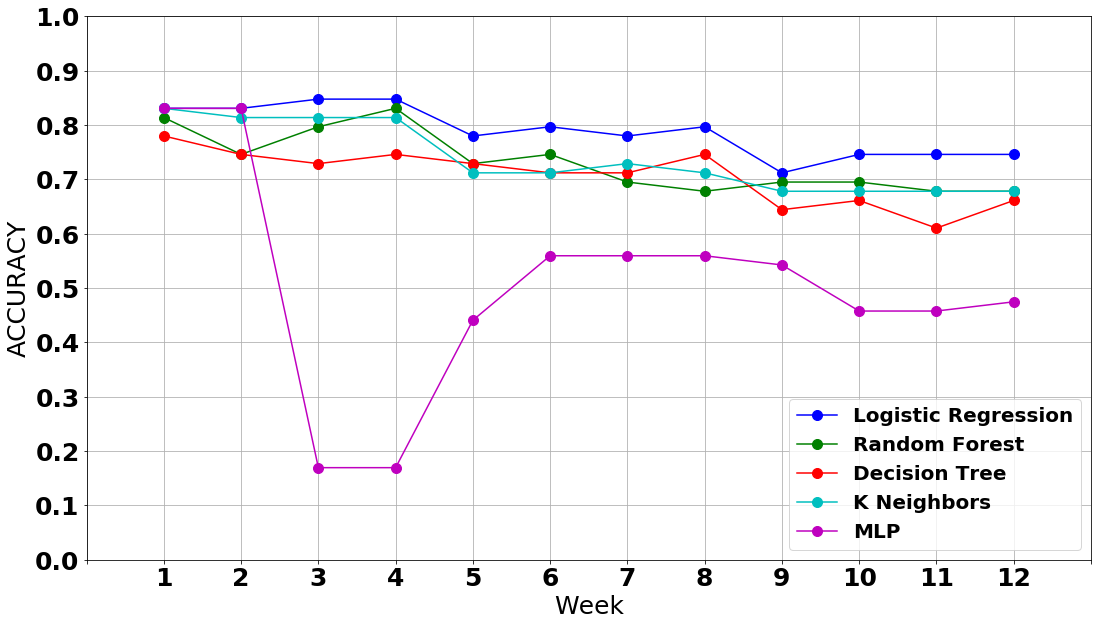

In [24]:
plot(acc_scores, 'accuracy', '../../figures/{}_empirical_risk_ACC.png'.format(_course.upper()))

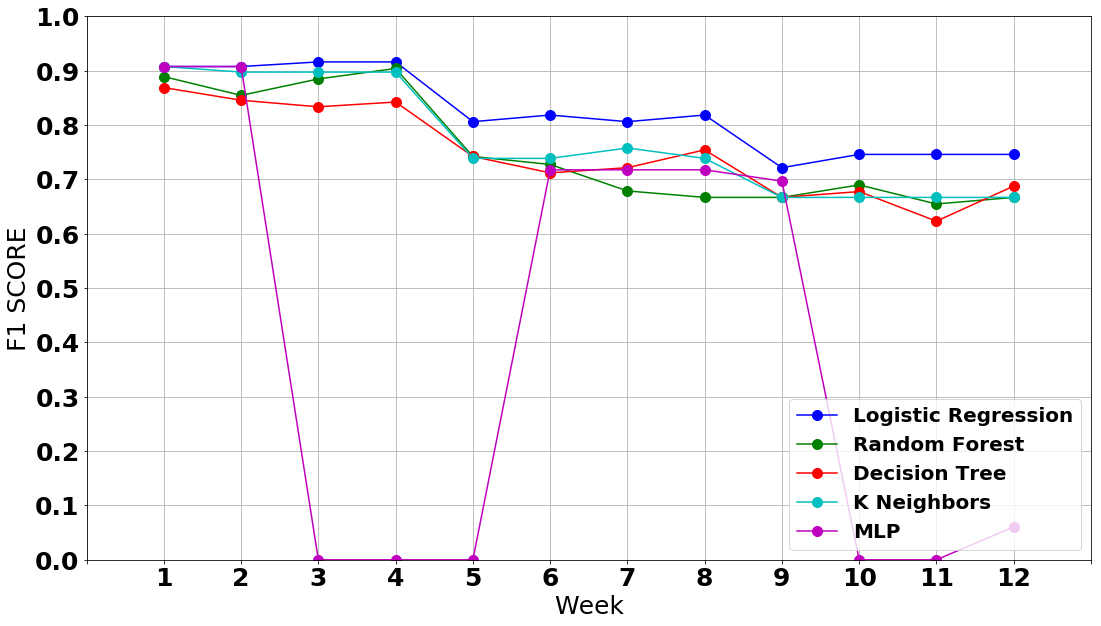

In [25]:
plot(f1_scores, 'f1_score', '../../figures/{}_empirical_risk_F1-Score.png'.format(_course.upper()))

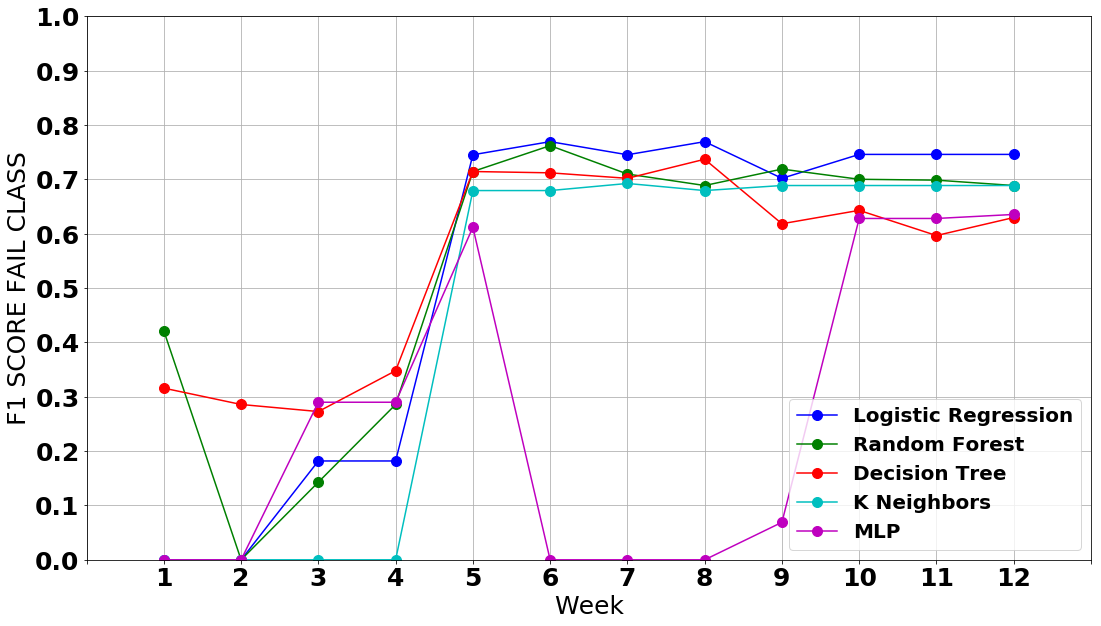

In [26]:
plot(f1_fail, 'f1_score_fail_class', '../../figures/{}_empirical_risk_F1-Score-Fail-Class.png'.format(_course.upper()))